<style type="text/css">
#image {
  float:left;
  border-right:1px;
  width:145px;
  height:145px;
  margin-top:1px;
  margin-left:50px;
  padding:1px;
  background-color:#ffffff;
}
#subject {
  float:left;
  width:500px;
  border-radius: 10px; 
  height:130px;
  margin-top:6px;
  padding:1px;
  background-color:#b0bc04;
}
</style>

<div id="image">
<img src="https://www.imt-atlantique.fr/sites/default/files/ecole/IMT_Atlantique_logo.png" WIDTH=240 HEIGHT=240>
</div>
<div id="subject">
<CENTER>
</br>

<font size="5">TAF MCE - UE Computer Vision | Lab Session 2 : Image interpretation </font></br></div>

<CENTER>
P.-H. Conze <span style="color:blue">pierre-henri.conze@imt-atlantique.fr</span> - 
R. Fablet <span style="color:blue">ronan.fablet@imt-atlantique.fr</span>
<CENTER>
</CENTER>
</div> 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My\ Drive/Computer vision/TP2/TP2-notebook-student

/content/drive/My Drive/Computer vision/TP2/TP2-notebook-student


***
This lab session is dedicated to **image interpretation** with deep learning. Two topics will be studied and discussed: 

1. **semantic segmentation** 
2. **object detection** (single-object localization)

For these purposes, we exploit an annotated dataset of pets, called **Oxford-IIIT-Pet** and covering 37 different breeds of cats and dogs. In particular, we focus on 200 images obtained for the *samoyed* category (https://www.robots.ox.ac.uk/~vgg/data/pets/getCategory.php?category=samoyed).

<div id="image">
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e0/1926_Samoyed_CHPolarLight.jpg" WIDTH=240 HEIGHT=240>
</div>
<div id="subject">
<CENTER>
</br>

Each image is annotated with a breed label (*samoyed* in our case), a pixel level segmentation marking the body, and a tight bounding box around the head.
***

## I - Semantic segmentation

Our goal is to create a fully-automated **semantic segmentation model** with deep learning able to accurately delineate *samoyed* dogs in each image.

**Question 1 -** Read and display the three first images ("samoyed_i" with i={1,2,3}) with associated segmentation masks.

In [0]:
from skimage import io

folder_img = './samoyed_img/' 
folder_seg = './samoyed_seg/'
img1 = io.imread(folder_img+"samoyed_1.jpg", as_gray=True)
seg1 = io.imread(folder_seg+"samoyed_1.png", as_gray=True)
img2 = io.imread(folder_img+"samoyed_2.jpg", as_gray=True)
seg2 = io.imread(folder_seg+"samoyed_2.png", as_gray=True)
img3 = io.imread(folder_img+"samoyed_3.jpg", as_gray=True)
seg3 = io.imread(folder_seg+"samoyed_3.png", as_gray=True)

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12))
plt.subplot(321)
plt.imshow(img1)
plt.subplot(322)
plt.imshow(seg1)
plt.subplot(323)
plt.imshow(img2)
plt.subplot(324)
plt.imshow(seg2)
plt.subplot(325)
plt.imshow(img3)
plt.subplot(326)
plt.imshow(seg3)
plt.show()

Groundtruth masks are **trimaps** with regions corresponding to: pet body (label 1), background (label 2) and ambiguous (pet body boundaries and/or any accessory such as collars) areas (label 3)

The function provided below list all the files in the *path* folder (except hidden files).

In [0]:
import numpy as np
import os
def listdir_nohidden(path):
    l = []
    for f in np.sort(os.listdir(path)) :
        if f.startswith('.') == False :
            l.append(f)
    return l

**Question 2 -** Store images and associated masks in single array structures (**imgs** and **segs**) after 64$\times$64 reshaping for further deep learning processing. Background and ambiguous areas will be labeled as 0, pet body regions at 1.

In [0]:
from skimage.transform import resize

size_ = 64
list_ = listdir_nohidden(folder_img)
list_ = list_[1:]
imgs = np.ndarray((len(list_), size_, size_, 3), dtype=np.float32)
segs = np.ndarray((len(list_), size_, size_, 1), dtype=np.uint8)
idxs = []

for idx, id_ in enumerate(list_):
    name = id_.split('.')[0]
    img = io.imread(folder_img+id_)
    seg = io.imread(folder_seg+name+'.png')
    imgs[idx,:,:,:] = resize(img, (size_,size_, 3), mode='reflect', preserve_range=True) 
    segs[idx,:,:,0] = resize(seg, (size_, size_), mode='reflect', preserve_range=True, anti_aliasing_sigma=3).astype(np.uint8)
    # TO DO # background/ambiguous areas at 0, pet body regions at 1
    segs= np.where(segs==1, segs, 0)
    idxs.append(name)

**Question 3 -** Implement and apply a function **normalization()** which standardizes the dataset (center to the mean and component wise scale to unit variance).

In [0]:
def normalization(imgs):
    imgs = imgs.astype('float32', copy=False)
    for i in range(imgs.shape[0]):
        img_noNor = imgs[i,:,:,:]
        mean = np.mean(img_noNor, keepdims=True, axis=(0,1))
        var = np.std(img_noNor, keepdims=True, axis=(0,1))
        img_Nor = (img_noNor - mean)/var
        imgs[i,:,:,:] = img_Nor
    return imgs
imgs = normalization(imgs)  

Let us display the first four images with associated groundtruth masks.

In [8]:
from skimage.exposure import rescale_intensity

plt.figure(figsize=(18, 4))
plt.subplot(181)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[0], in_range=(np.min(imgs[0]),np.max(imgs[0])), out_range=(0,1)))
plt.subplot(182)
plt.axis('off')
plt.imshow(segs[0,:,:,0], cmap='gray')
plt.subplot(183)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[1], in_range=(np.min(imgs[1]),np.max(imgs[1])), out_range=(0,1)))
plt.subplot(184)
plt.axis('off')
plt.imshow(segs[1,:,:,0], cmap='gray')
plt.subplot(185)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[2], in_range=(np.min(imgs[2]),np.max(imgs[2])), out_range=(0,1)))
plt.subplot(186)
plt.axis('off')
plt.imshow(segs[2,:,:,0], cmap='gray')
plt.subplot(187)
plt.axis('off')
plt.imshow(rescale_intensity(imgs[3], in_range=(np.min(imgs[3]),np.max(imgs[3])), out_range=(0,1)))
plt.subplot(188)
plt.axis('off')
plt.imshow(segs[3,:,:,0], cmap='gray')
plt.show()

**Question 4 -** Divide the dataset into 2 subsets. The first 80% will belong to the training set, the last 20% to the test set.

In [0]:
ratio = 0.8
split = np.int(len(imgs)*ratio)
train_imgs = imgs[:split,:,:,:] # training images
train_segs = segs[:split,:,:,:]# training segmentation masks
test_imgs = imgs[split:,:,:,:] # test images
test_segs = segs[split:,:,:,:] # test segmentation masks
train_idxs = idxs[:split] # training image ids
test_idxs = imgs[split:]# test image ids

The functions provided below aims at computing the dice score which will be used as loss function in our deep learning networks. 

In [0]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

Rather than extracting individual patches from the image and classifying these patches independently, we will first employ a stack of convolutional layers preserving the spatial size of the input --> **Fully Convolutional Networks** (FCN).

**Question 5 -** Implement a FCN network with 7 convolutional layers: 2 with 32 3x3 filters and Rectified Linear Unit (ReLU) activation, 2 with 64 3x3 filters and ReLU activation, 2 with 128 3x3 filters and ReLU activation as well as a final 1x1 convolutional layer with sigmoid activation to achieve pixel-wise segmentation.

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D
from keras.optimizers import Adam
from keras import backend as K

def get_model_1(img_rows, img_cols, prediction_weights=None):
    
    inputs = Input((img_rows, img_cols, 3))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)
    
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)
    
    conv7 = Conv2D(1, (1, 1), activation='sigmoid', padding='same', kernel_initializer = 'he_normal')(conv6)

    model = Model(inputs=[inputs], outputs=[conv7])
    if prediction_weights != None:
        model.load_weights(prediction_weights)

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
    return model

Using TensorFlow backend.


Let us now display the network architecture (with **model.summary()**), define the batch size and the number of epochs, defined the model checkpoint (https://keras.io/callbacks/), run the training (with **model.fit()**) and display how the dice score evolves during training for both training and test datasets.

In [12]:
model_1 = get_model_1(size_, size_)
model_1.summary()





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 128)       

In [0]:
batch_size = 10
epochs = 200

In [0]:
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('./weights.hdf5', monitor='val_dice_coef', verbose=0, save_best_only=True, save_weights_only=True, mode='max', period=1)

Using the option **save_best_only=True**, the latest best model according to the quantity monitored (**val_dice_coef**) will not be overwritten.

In [15]:
hist_1 = model_1.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])




Train on 160 samples, validate on 40 samples
Epoch 1/200





160/160 [==============================] - 15s 95ms/step - loss: -0.4648 - dice_coef: 0.4648 - val_loss: -0.5865 - val_dice_coef: 0.5865
Epoch 2/200
160/160 [==============================] - 0s 2ms/step - loss: -0.6064 - dice_coef: 0.6064 - val_loss: -0.6413 - val_dice_coef: 0.6413
Epoch 3/200
160/160 [==============================] - 0s 2ms/step - loss: -0.6346 - dice_coef: 0.6346 - val_loss: -0.6540 - val_dice_coef: 0.6540
Epoch 4/200
160/160 [==============================] - 0s 2ms/step - loss: -0.6412 - dice_coef: 0.6412 - val_loss: -0.6604 - val_dice_coef: 0.6604
Epoch 5/200
160/160 [==============================] - 0s 2ms/step - loss: -0.6477 - dice_coef: 0.6477 - val_loss: -0.6606 - val_dice_coef: 0.6606
Epoch 6/200
160/160 [==============================] - 0s 2ms/step - loss: -0.6560 - dice_coef: 0.6560 - val_loss: -0.6679 - val_dice_coef: 0.6679
Epoch 7/200
160/160 [==============================] - 0s 2ms/s

In [0]:
def display_history(hist):
    plt.plot(hist.history['dice_coef'])
    plt.plot(hist.history['val_dice_coef'])
    plt.title('dice_coef and val_dice_coef')
    plt.ylabel('dice')
    plt.ylim([0,1])     
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [17]:
display_history(hist_1)

In [0]:
def dice_assessment(result, GT, label=1):
    A = GT == label
    B = result == label            
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    TN = len(np.nonzero((~A)*(~B))[0])
    dice = 0
    if (FP+2*TP+FN) != 0 : 
        dice = float(2)*TP/(FP+2*TP+FN)
    return dice

In [0]:
from skimage.segmentation import mark_boundaries

def visualize_predicted_boundary(img, pred, groundtruth):
    img = rescale_intensity(img, in_range=(np.min(img),np.max(img)), out_range=(0,1))
    out = mark_boundaries(img, groundtruth, color=(0, 1, 0), background_label=4)
    out = mark_boundaries(out, pred, color=(1, 0, 0), background_label=2)
    return out

**Question 6 -** Using the provided **dice_assessment()** and **visualize_predicted_boundary()** functions to be read and understood, implement and apply **make_prediction()** to provide for each test image the predicted segmentation mask as well as the dice score. Dice scores will be stored in the array **dices**. What is the average dice score obtained for the test set?

In [0]:
def make_prediction(model, test_idxs, test_imgs, test_segs):
    dices = []
    model.load_weights('./weights.hdf5')
    for idx, id_ in enumerate(test_idxs):
        pred =model.predict(test_imgs[idx,:,:,:].reshape(1,64,64,3)).astype(np.uint8) # prediction
        groundtruth = test_segs[idx,:,:,:]
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.axis('off')
        plt.imshow(rescale_intensity(test_imgs[idx], in_range=(np.min(test_imgs[idx]),np.max(test_imgs[idx])), out_range=(0,1)))
        plt.subplot(132)
        plt.axis('off')
        plt.imshow(pred[0,:,:,0], cmap='gray')
        plt.subplot(133)
        plt.axis('off')
        plt.imshow(visualize_predicted_boundary(test_imgs[idx], pred[0,:,:,0], groundtruth[:,:,0]))  # image with super-imposed prediction and groundruth 
        plt.show()
        dice = dice_assessment(pred, groundtruth)
        #print(id_, 'dice :',dice)
        dices.append(dice)
    return np.array(dices)

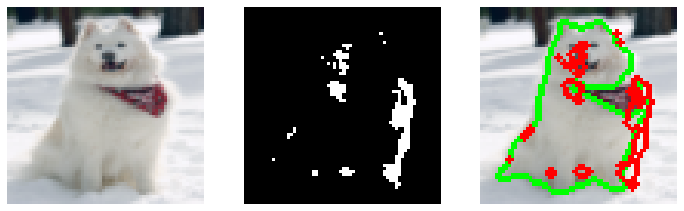

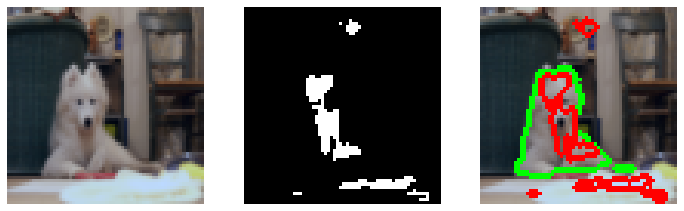

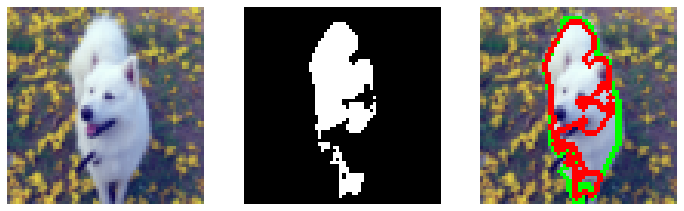

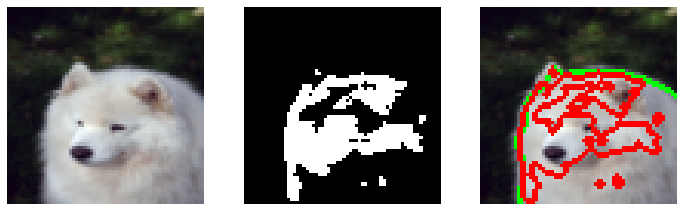

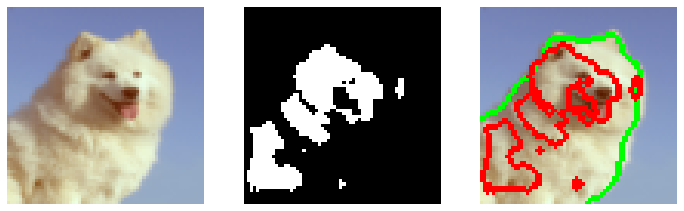

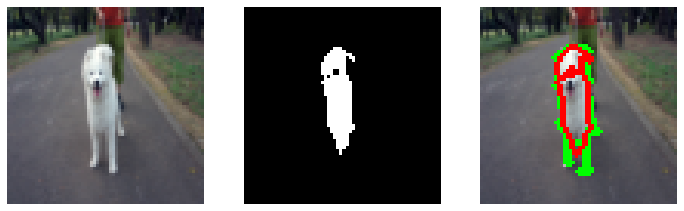

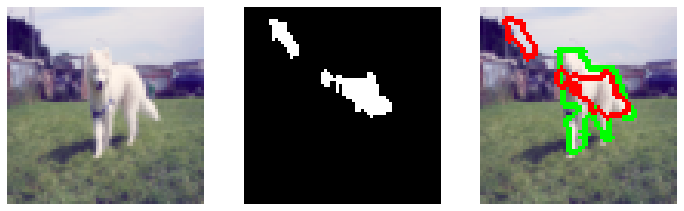

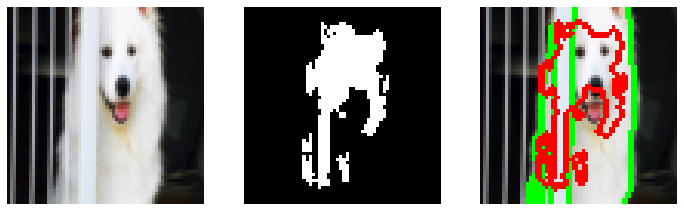

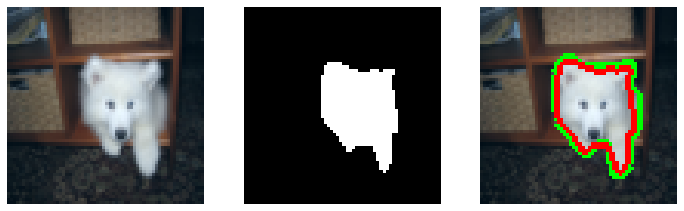

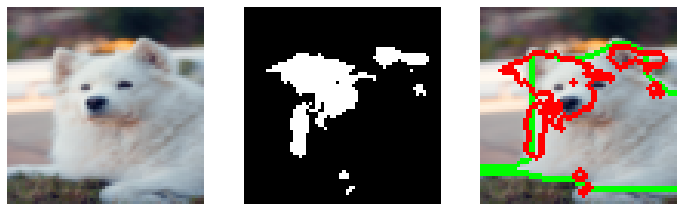

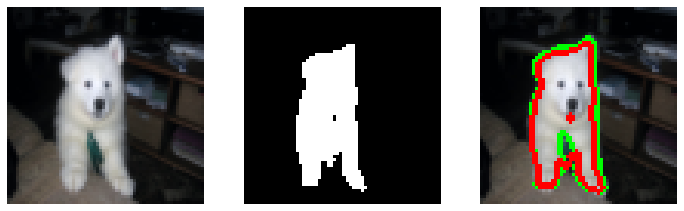

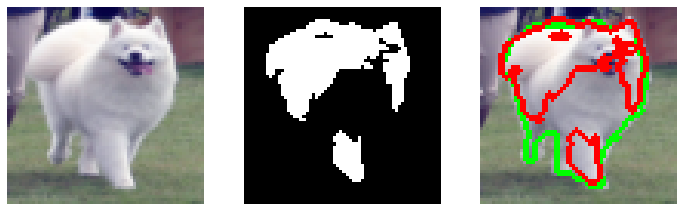

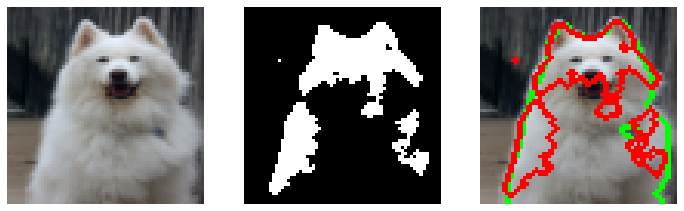

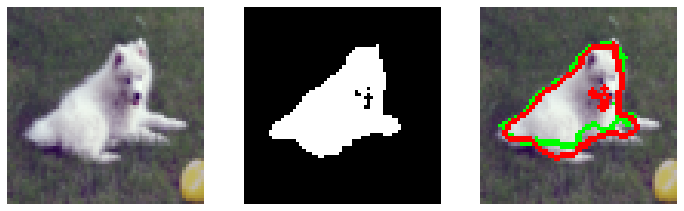

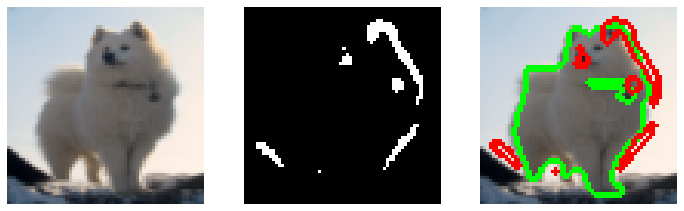

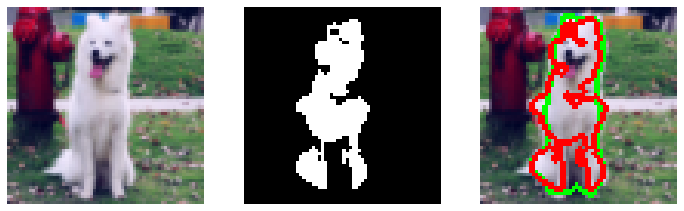

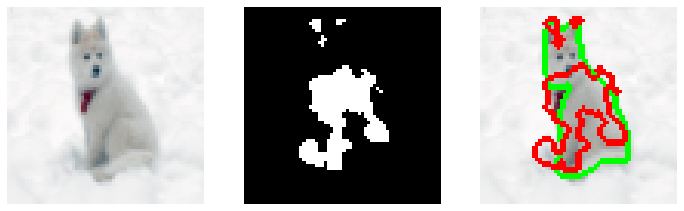

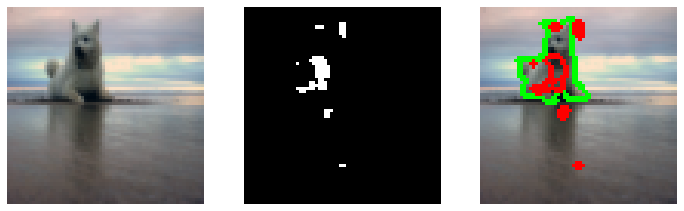

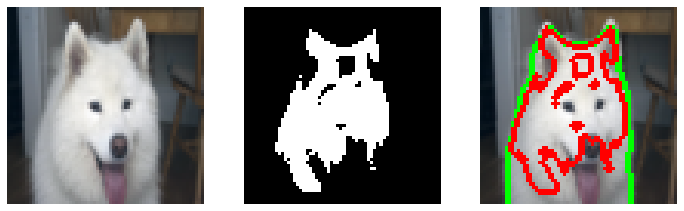

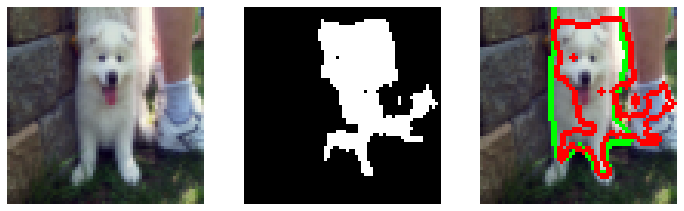

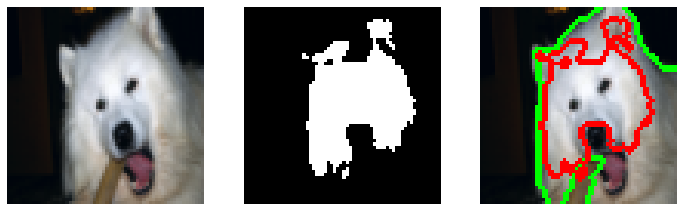

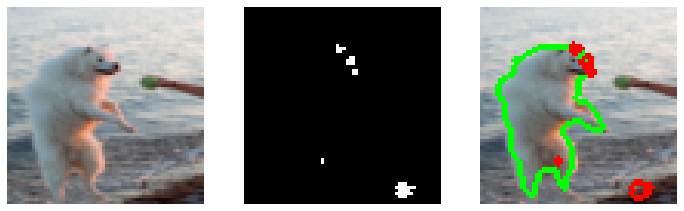

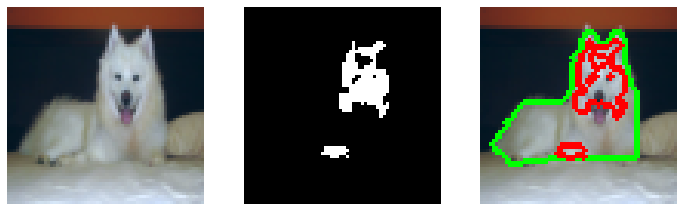

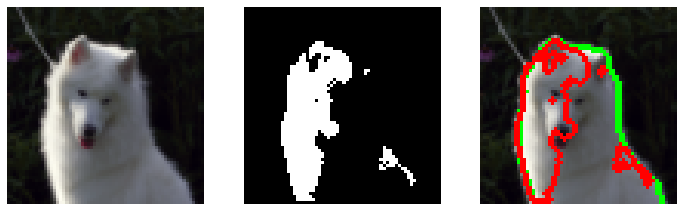

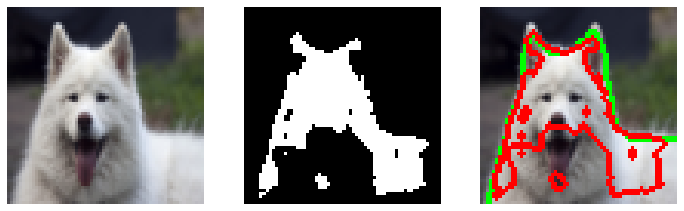

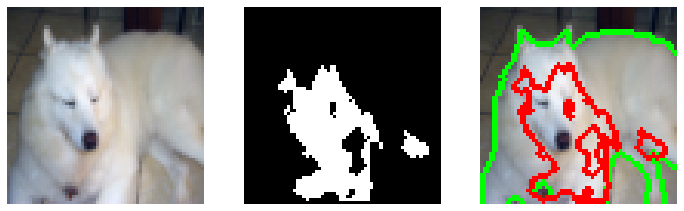

average dice: 0.5698937865603387


In [21]:
dices_1 = make_prediction(model_1, test_idxs, test_imgs, test_segs)
print('average dice:', np.mean(dices_1))

Better deep learning networks can be reached using some downsampling and upsampling operations.

**Question 7 -** Implement a new network consisting of patterns of 2 convolutional layers followed by a pooling (resp. upsampling) layer for encoding (decoding) branches using **MaxPooling2D** (**Conv2DTranspose**). Convolutional layers will exploit 3x3 filters followed by ReLU activations. Spatial size will be reduced (increased) with 2×2 max pooling (upsampling) layers. The 2 first convolutional layer will generate 32 channels. This number will double after each pattern.

In [0]:
from keras.layers import MaxPooling2D, Conv2DTranspose

def get_model_2(img_rows, img_cols, prediction_weights=None):
    
    inputs = Input((img_rows, img_cols, 3))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D()(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D()(conv2) 

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2) # central part
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3) # central part

    up4 = Conv2DTranspose(128,(2,2), padding='same', strides=(2,2))(conv3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)

    up5 = Conv2DTranspose(64,(2,2), padding='same', strides=(2,2))(conv4)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)

    conv6 = Conv2D(1, (1, 1), activation='sigmoid', padding='same', kernel_initializer = 'he_normal')(conv5)


    model = Model(inputs=[inputs], outputs=[conv6])
    if prediction_weights != None:
        model.load_weights(prediction_weights)    

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
    return model

**Question 8 -** Run the training and use **make_prediction()** to provide predicted segmentation masks. What is the average dice score obtained for the test set?



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0 

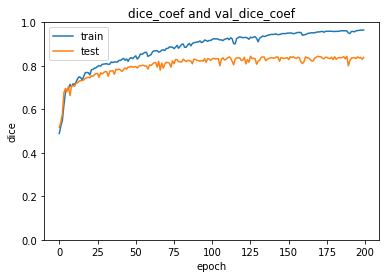

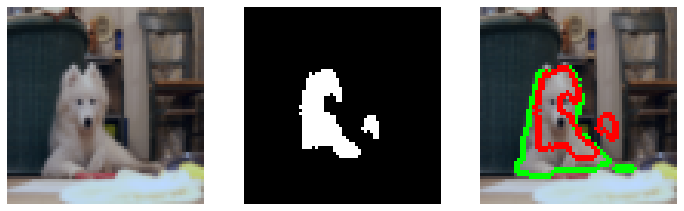

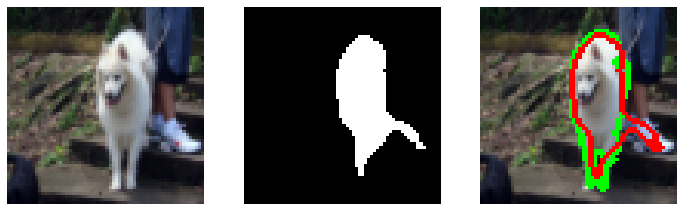

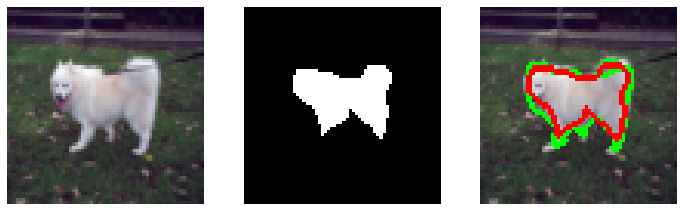

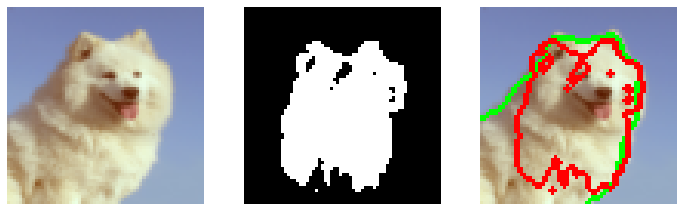

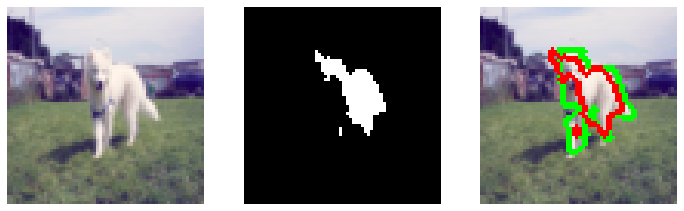

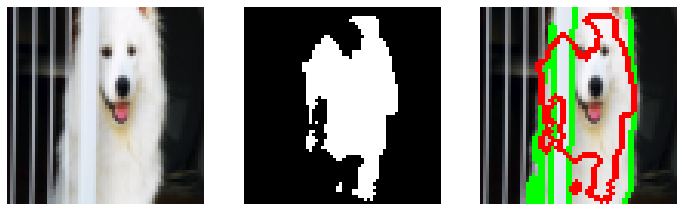

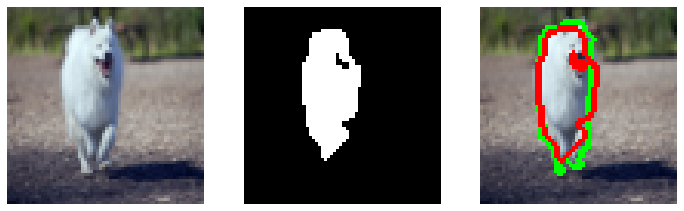

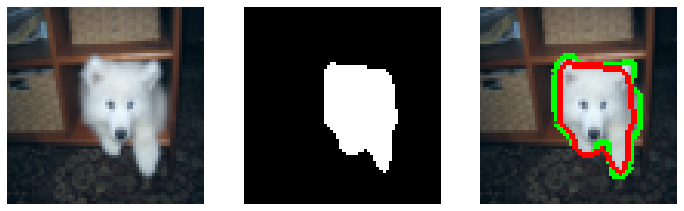

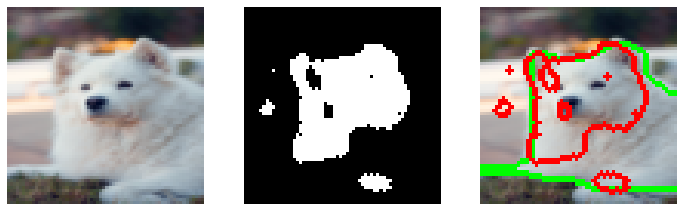

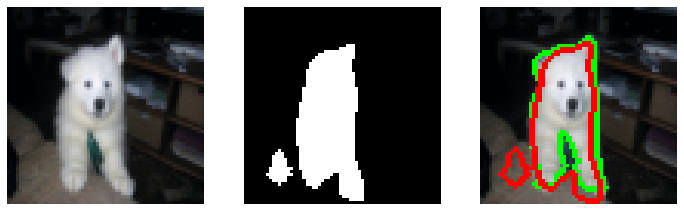

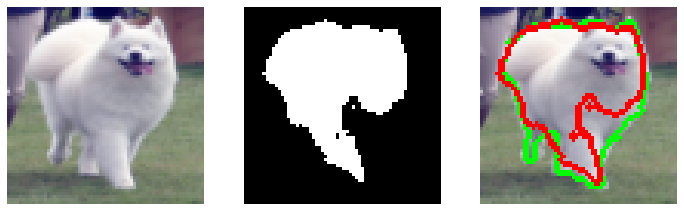

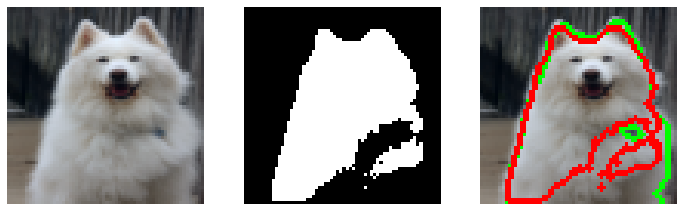

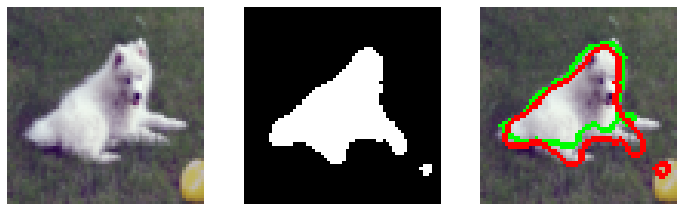

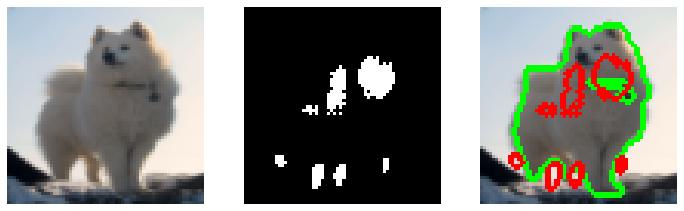

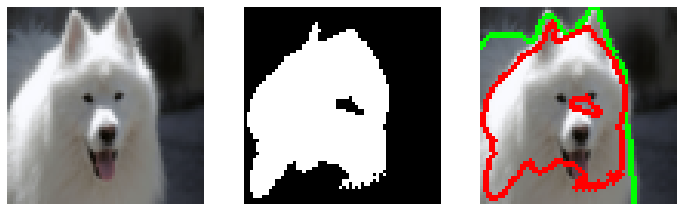

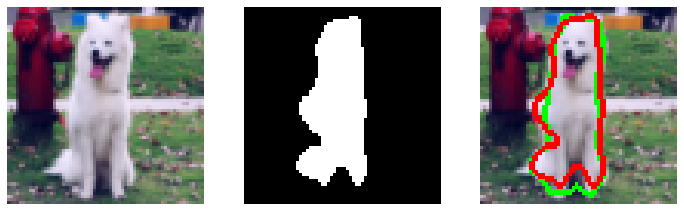

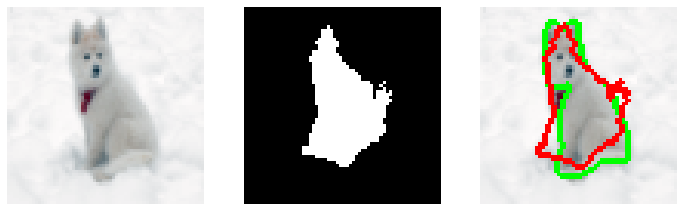

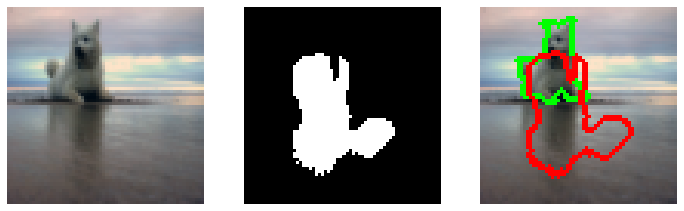

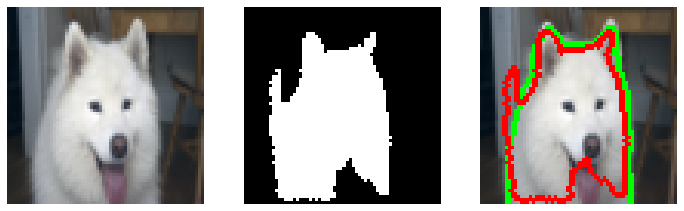

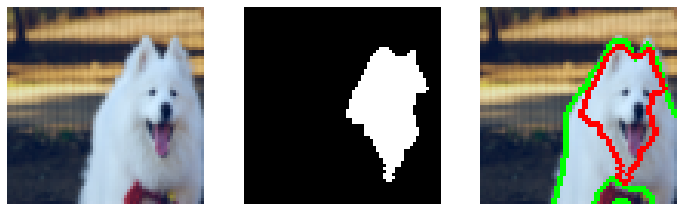

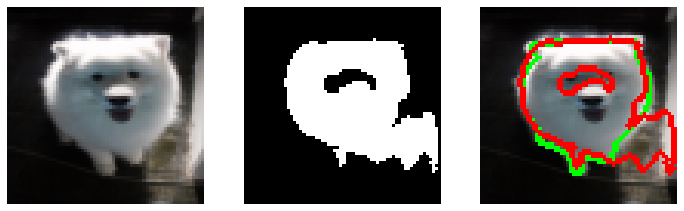

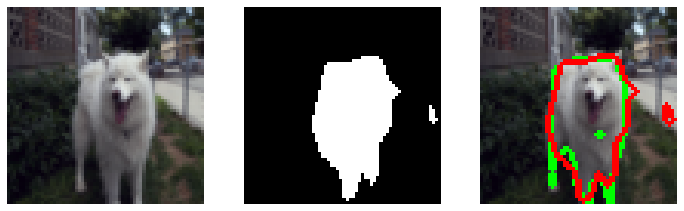

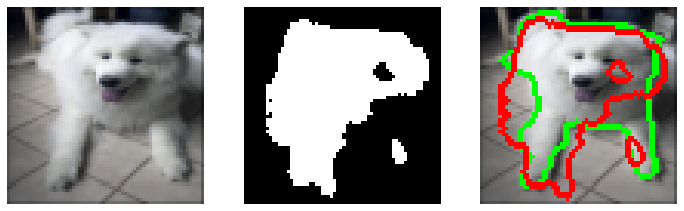

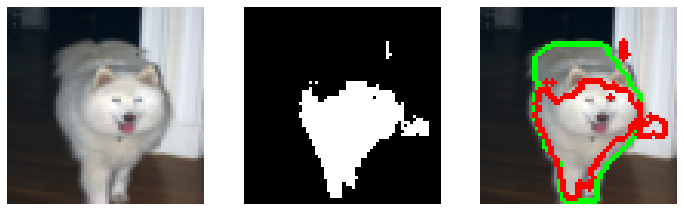

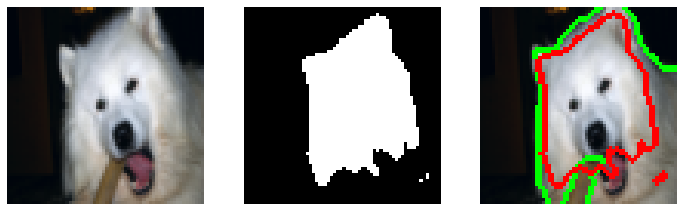

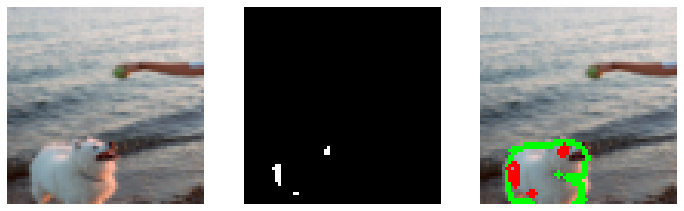

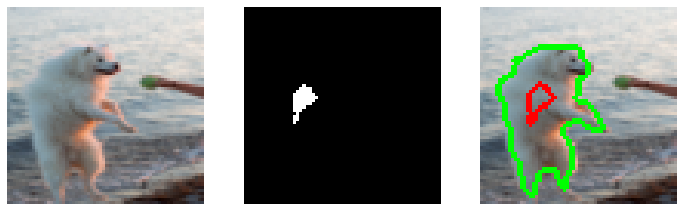

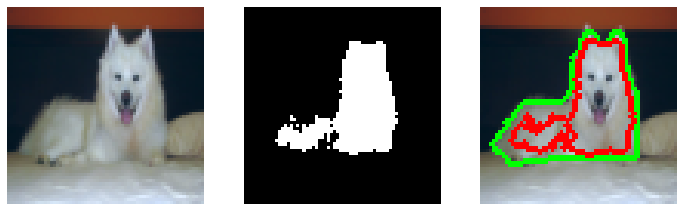

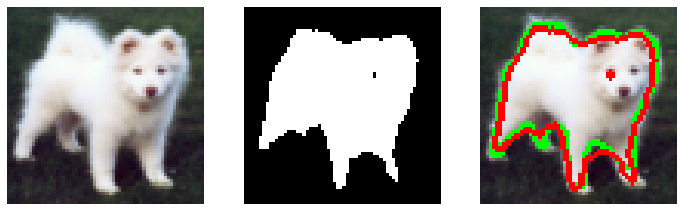

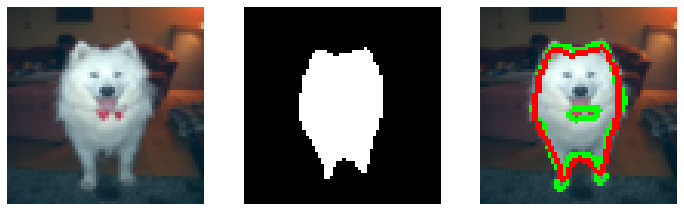

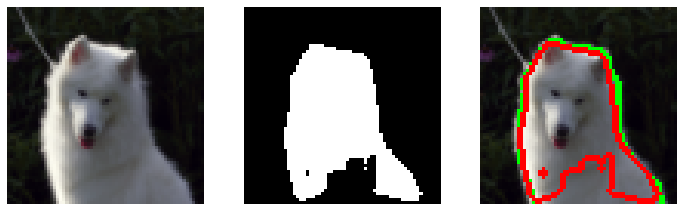

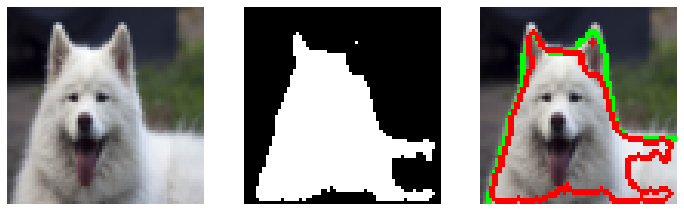

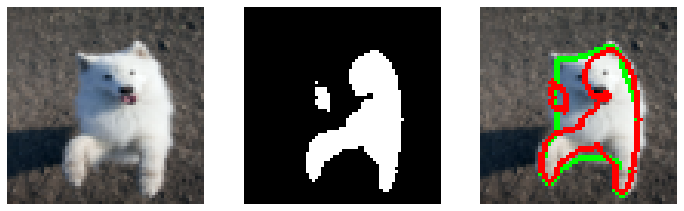

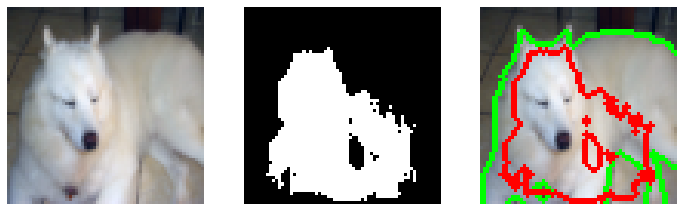

average dice: 0.73699382780254


In [23]:
model_2 = get_model_2(size_, size_)
model_2.summary()
hist_2 = model_2.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])
display_history(hist_2) 
dices_2 = make_prediction(model_2, test_idxs, test_imgs, test_segs)
print('average dice:', np.mean(dices_2))

**Question 9 -** Add skip connections (i.e. feature concatenation from the encoder to the decoder) to the network implemented in question 7 using **concatenate**. Run the training, evaluate and comment on the reached segmentation accuracy (especially in comparison to model 2).

In [0]:
from keras.layers import concatenate

def get_model_3(img_rows, img_cols, prediction_weights=None):
    
    inputs = Input((img_rows, img_cols, 3))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D()(conv1) 

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D()(conv2) 
 

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2) # central part
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3) # central part 

    up4 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv3), conv2], axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4) 

    up5 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv4), conv1], axis=3) 
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)

    conv6 = Conv2D(1, (1, 1), activation='sigmoid', padding='same', kernel_initializer = 'he_normal')(conv5) 

    model = Model(inputs=[inputs], outputs=[conv6])
    if prediction_weights != None:
        model.load_weights(prediction_weights)
        
    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
    return model

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 64, 64, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 64, 64, 32)   9248        conv2d_41[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_42[0][0]                  
____________________________________________________________________________________________

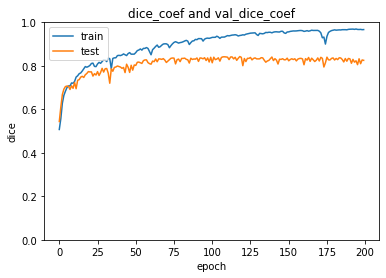

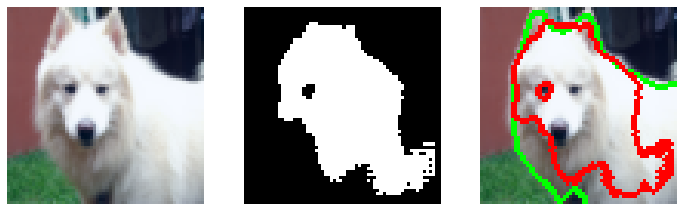

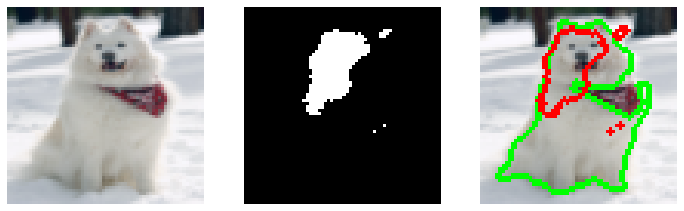

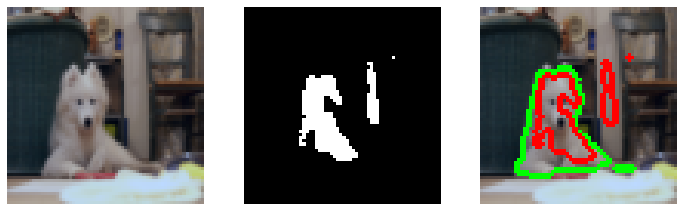

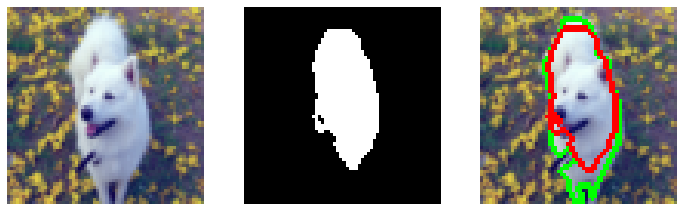

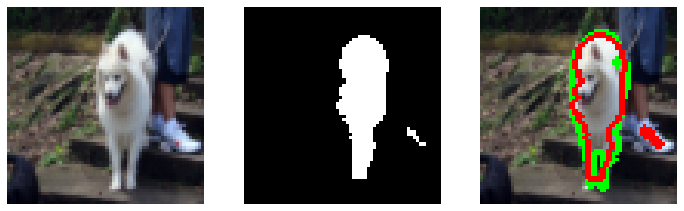

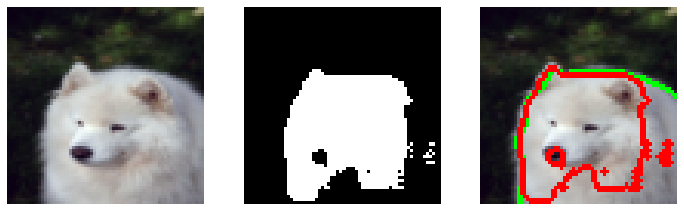

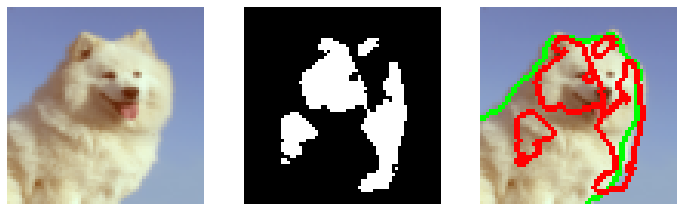

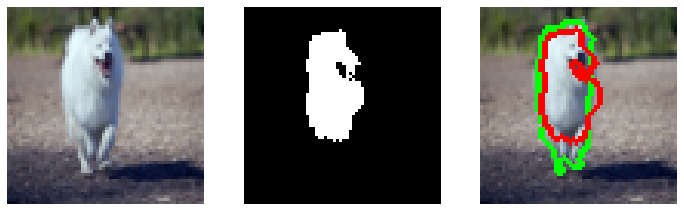

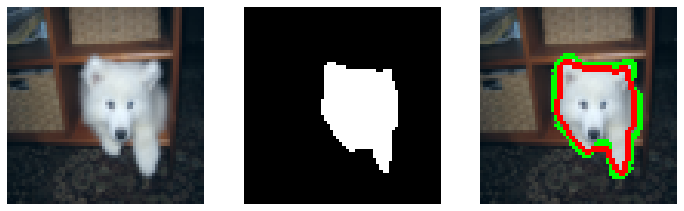

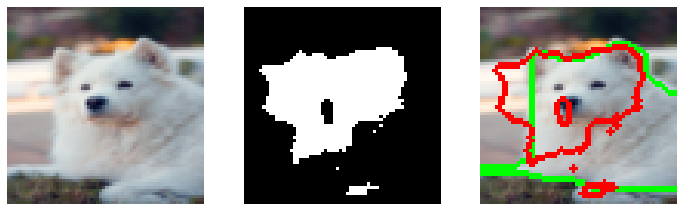

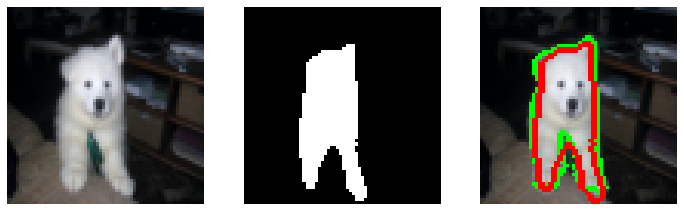

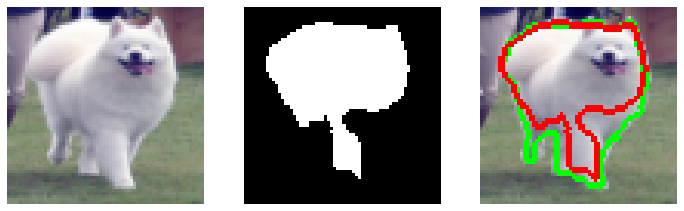

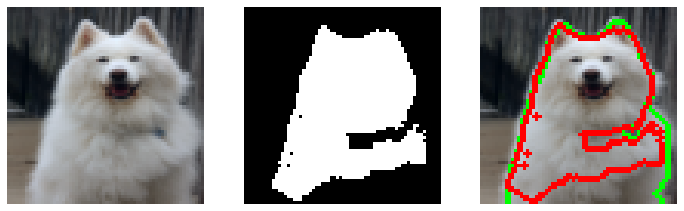

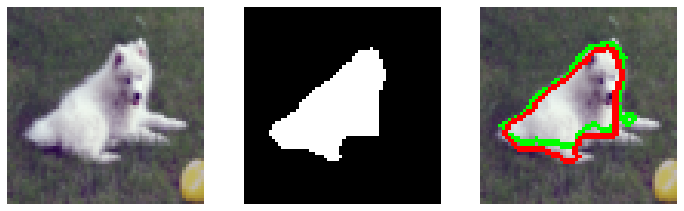

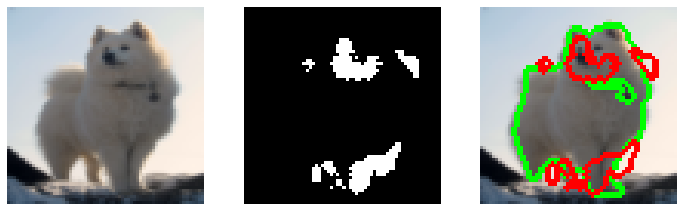

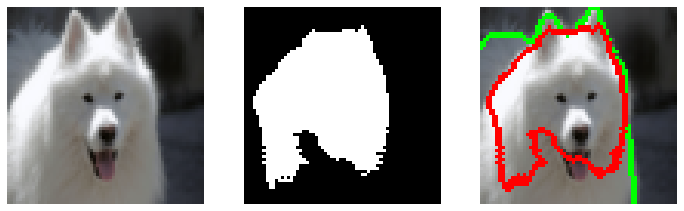

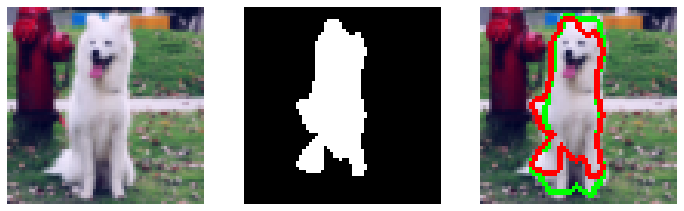

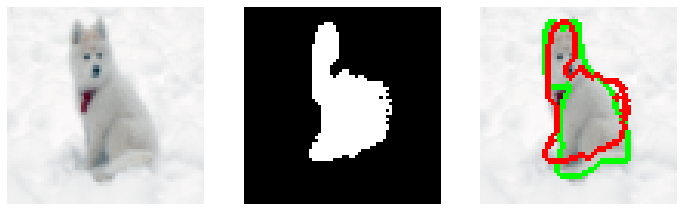

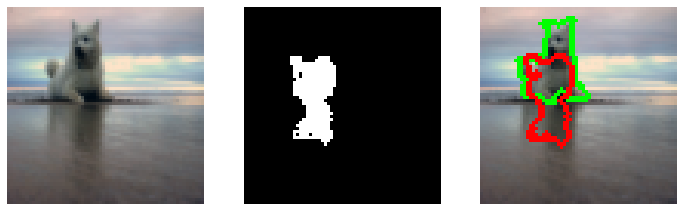

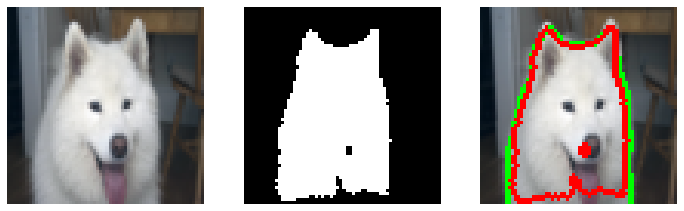

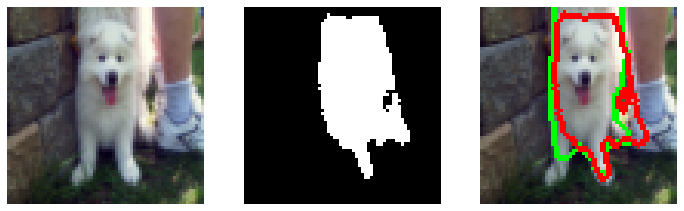

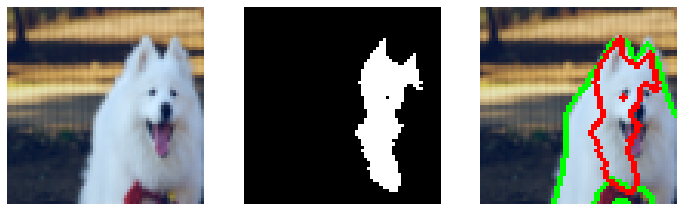

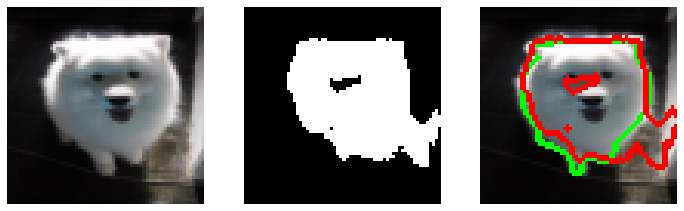

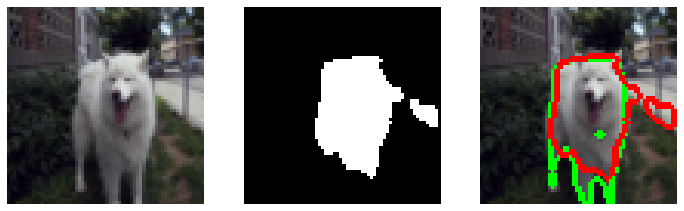

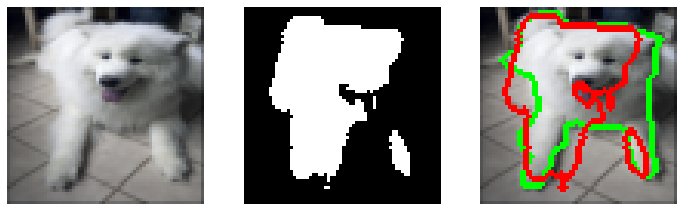

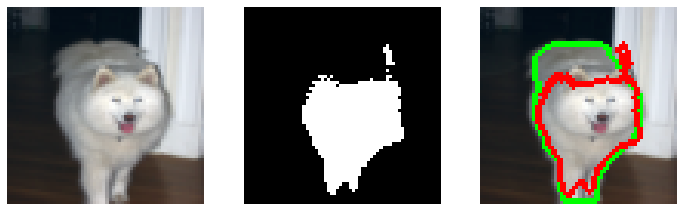

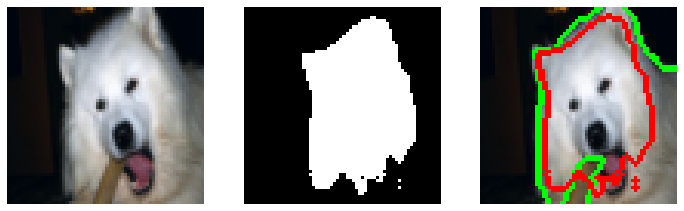

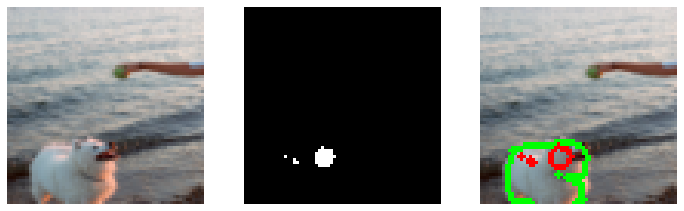

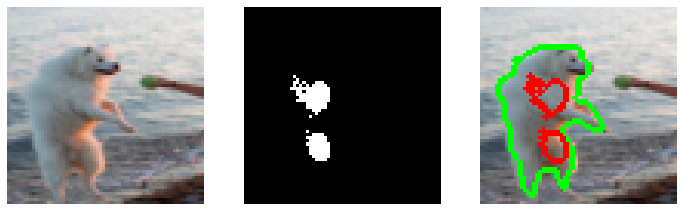

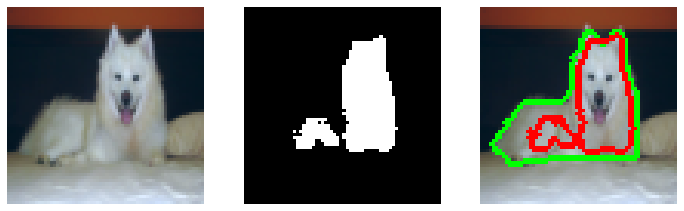

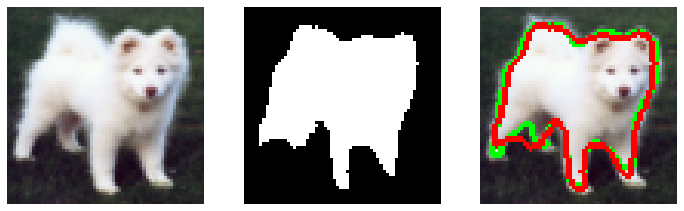

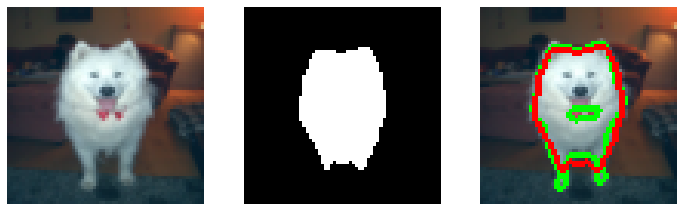

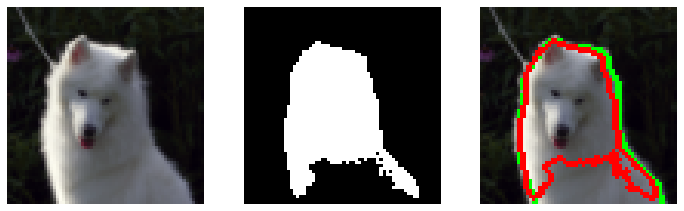

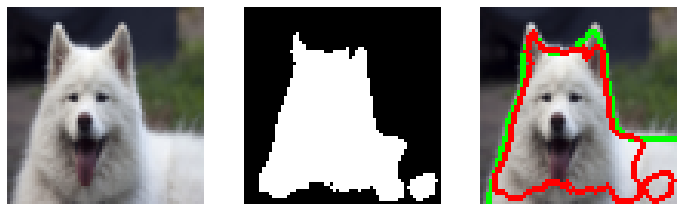

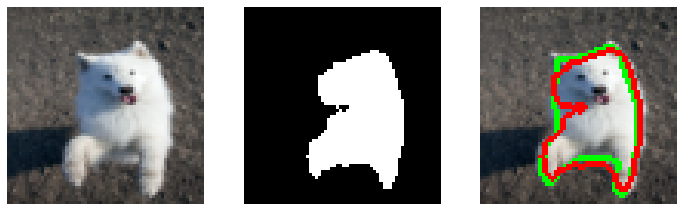

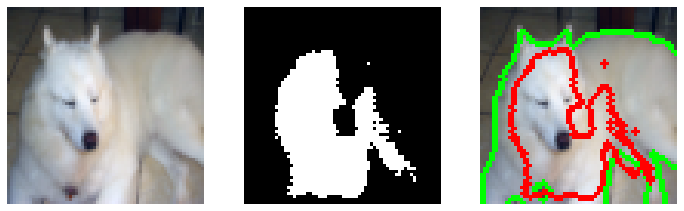

average dice: 0.7263453743550237


In [29]:
model_3 = get_model_3(size_, size_)
model_3.summary()
hist_3 = model_3.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])
display_history(hist_3) 
dices_3 = make_prediction(model_3, test_idxs, test_imgs, test_segs)
print('average dice:', np.mean(dices_3)) 

**Question 10 -** The two following deep models (4 and 5) use the VGG16 classification network without (model 4) and with (model 5) pre-training on the ImageNet dataset. Run the training for both networks and (as previously) evaluate them.

In [0]:
def get_model_4(img_rows, img_cols, prediction_weights=None):
    
    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    if prediction_weights != None:
        model.load_weights(prediction_weights)

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
    
    return model


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 64, 64, 64)   1792        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_52[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_53[0][0]                  
____________________________________________________________________________________________

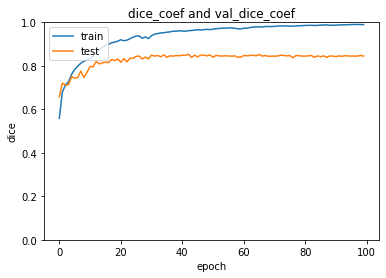

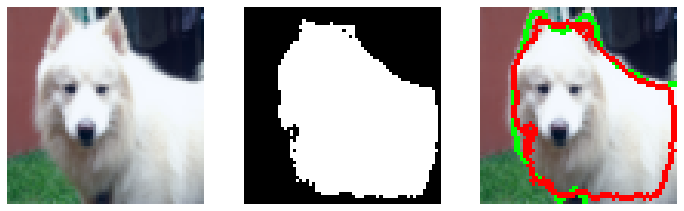

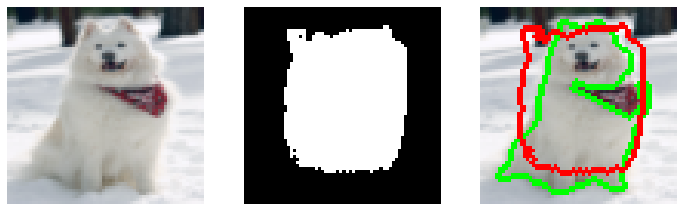

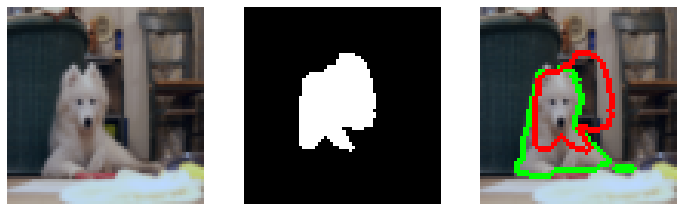

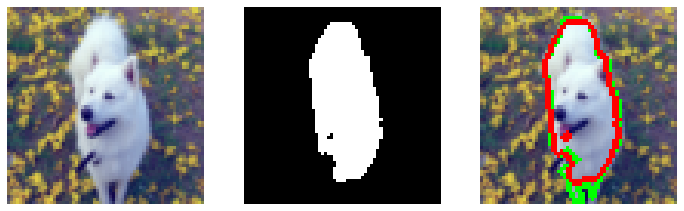

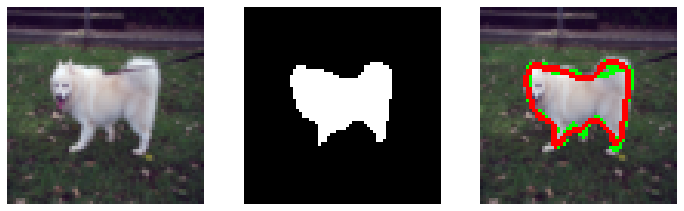

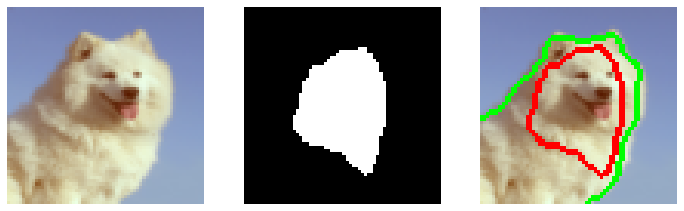

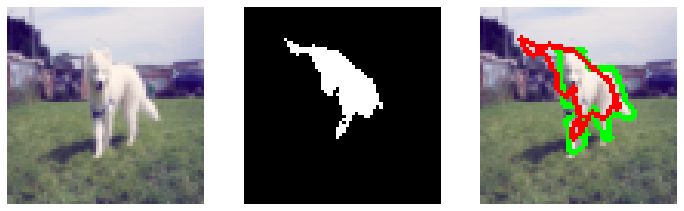

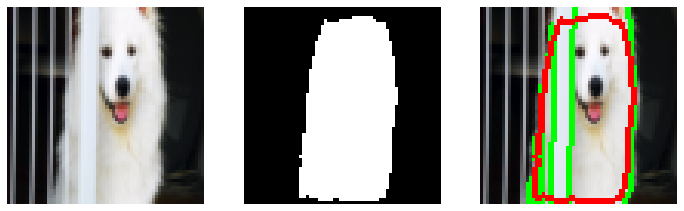

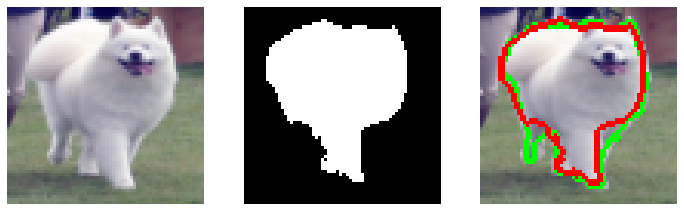

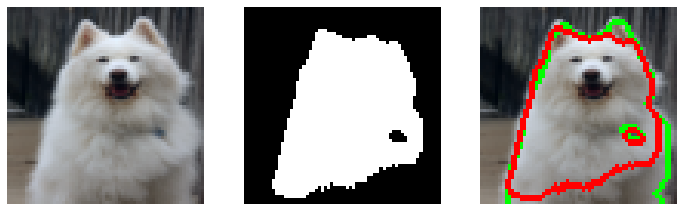

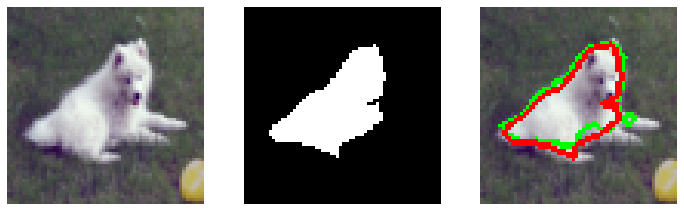

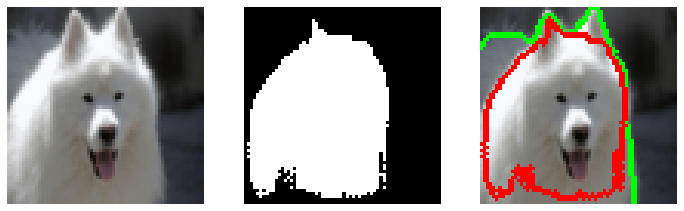

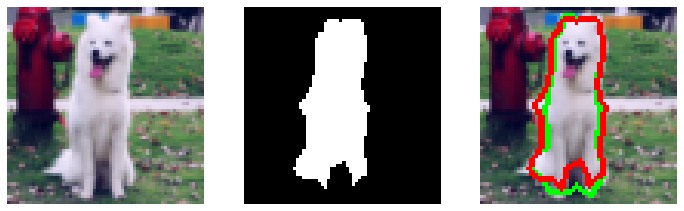

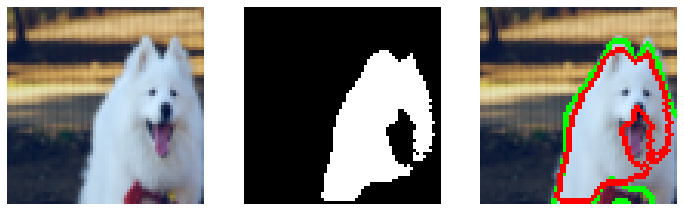

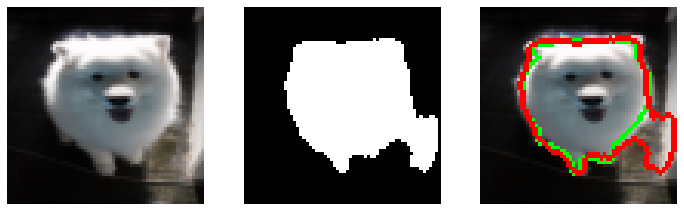

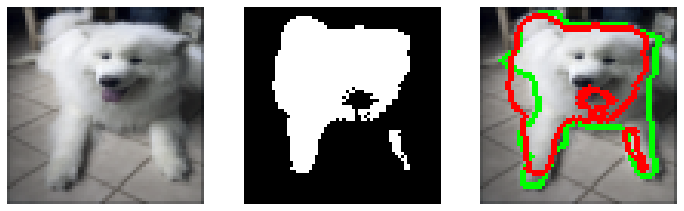

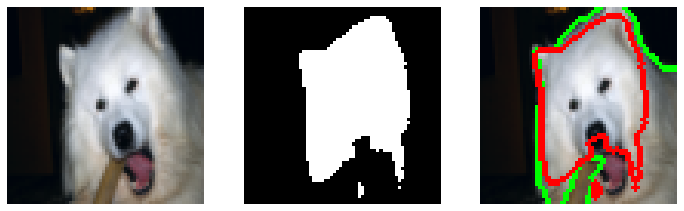

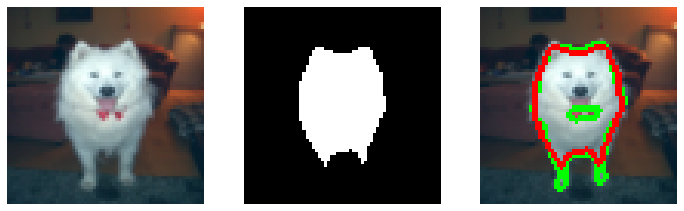

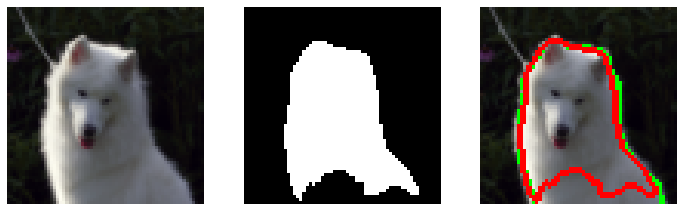

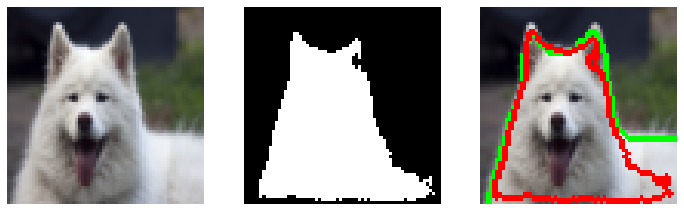

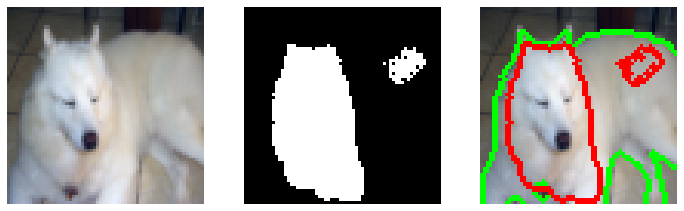

average dice: 0.7882801579122154


In [31]:
epochs = 100
model_4 = get_model_4(size_, size_)
model_4.summary()
hist_4 = model_4.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])
display_history(hist_4)
dices_4 = make_prediction(model_4, test_idxs, test_imgs, test_segs)
print('average dice:', np.mean(dices_4)) 

In [0]:
from keras.applications import vgg16

def get_model_5(img_rows, img_cols, prediction_weights=None):

    vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_rows,img_cols,3), pooling=None, classes=1000)
    
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(vgg16_model.get_layer('block5_conv3').output), vgg16_model.get_layer('block4_conv3').output], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv6), vgg16_model.get_layer('block3_conv3').output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv7), vgg16_model.get_layer('block2_conv2').output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(conv8), vgg16_model.get_layer('block1_conv2').output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal')(conv9)

    model = Model(inputs=[vgg16_model.layers[0].output], outputs=[conv10])
    if prediction_weights != None:
        model.load_weights(prediction_weights)

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
    
    return model

58892288/58889256 [==============================] - 2s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 32, 32, 64)   0           block1_conv2[0][0]               
___________________________

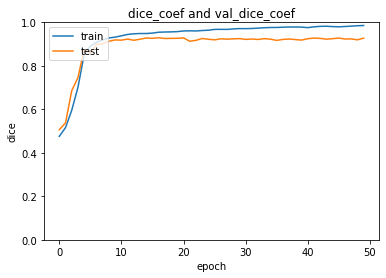

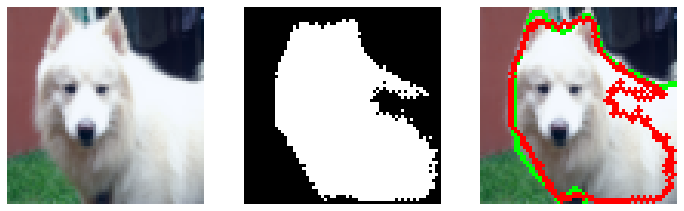

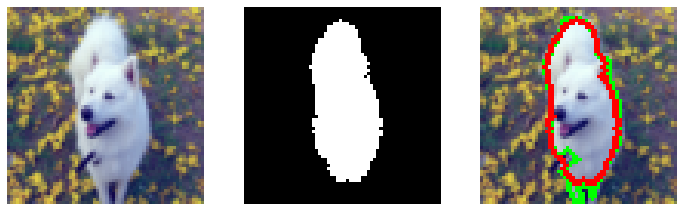

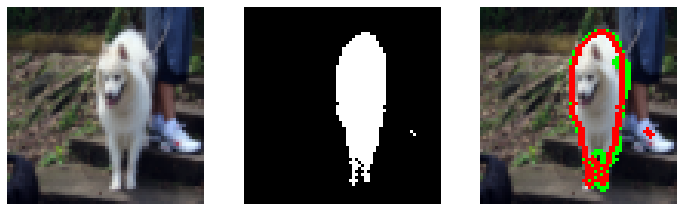

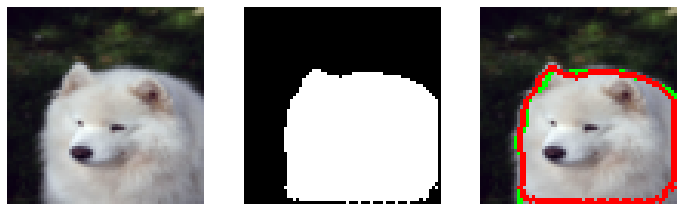

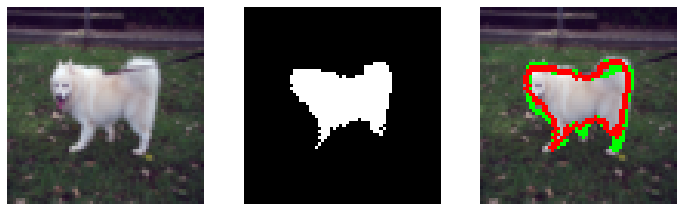

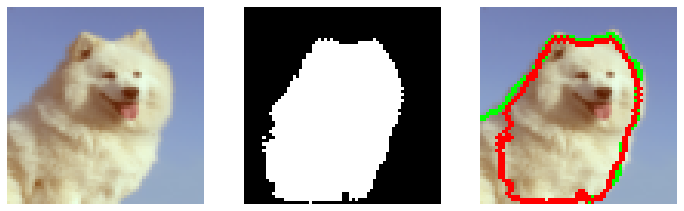

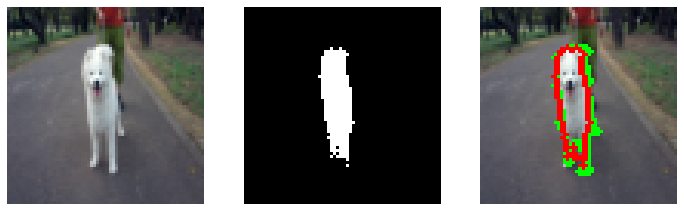

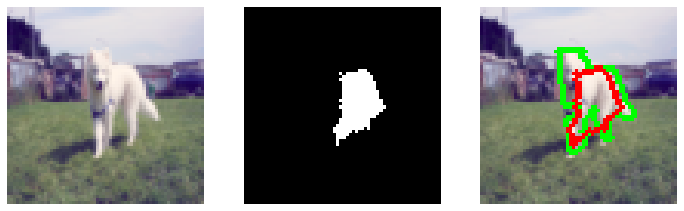

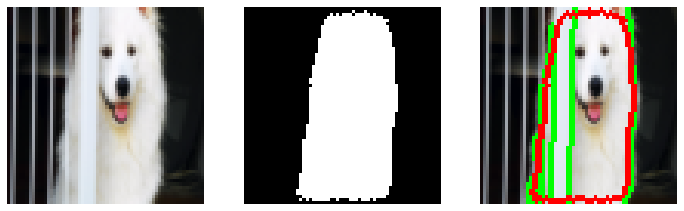

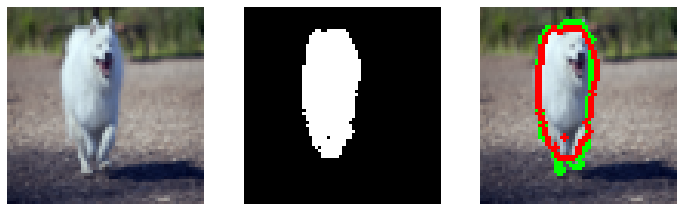

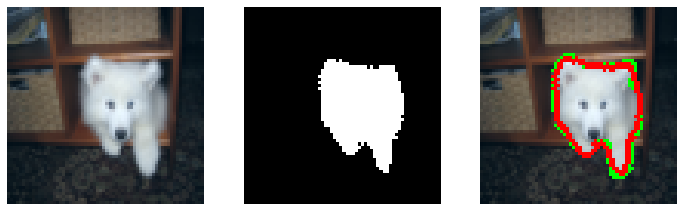

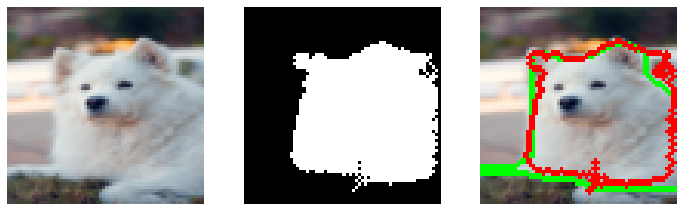

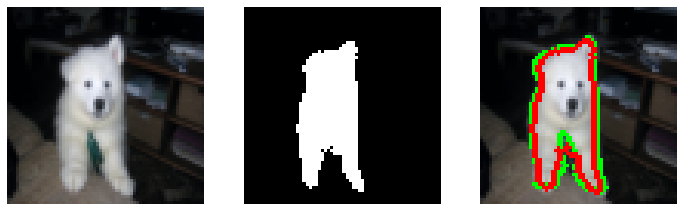

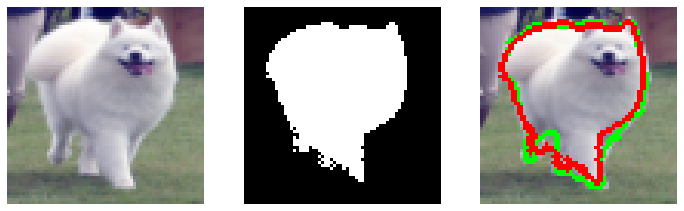

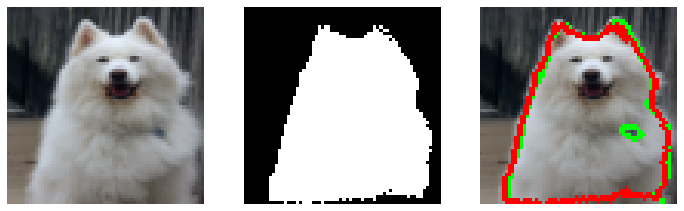

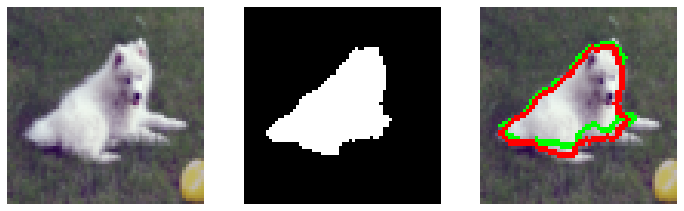

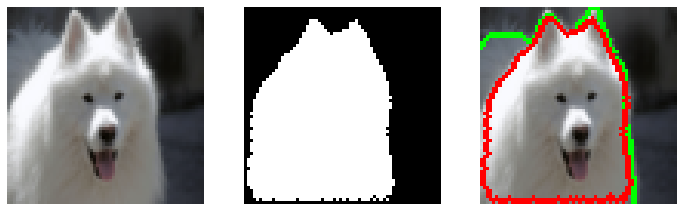

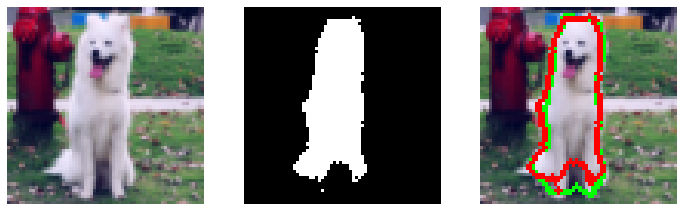

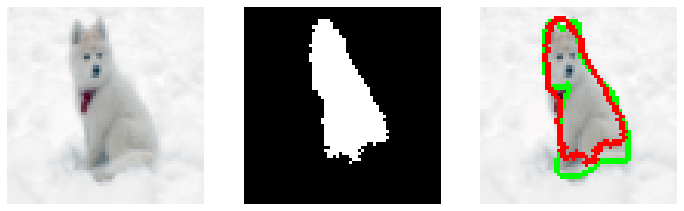

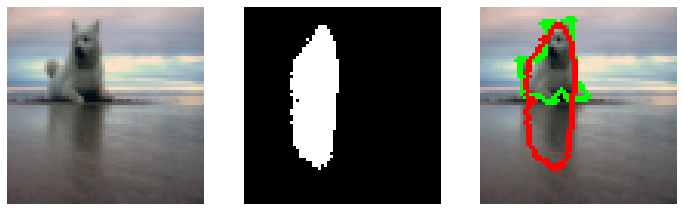

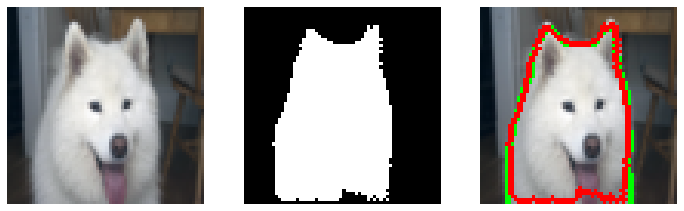

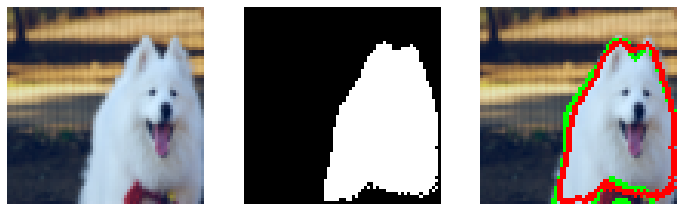

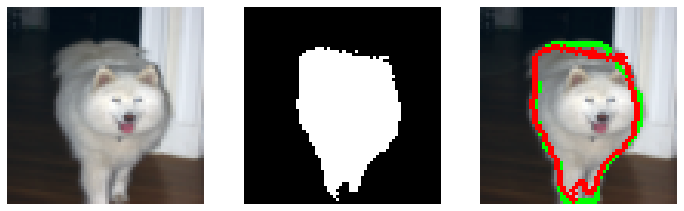

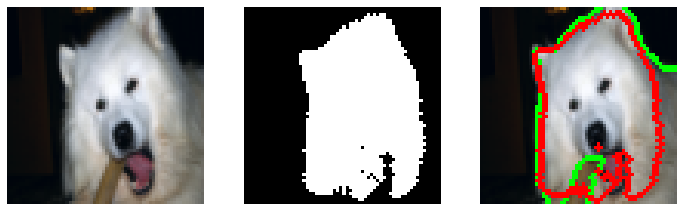

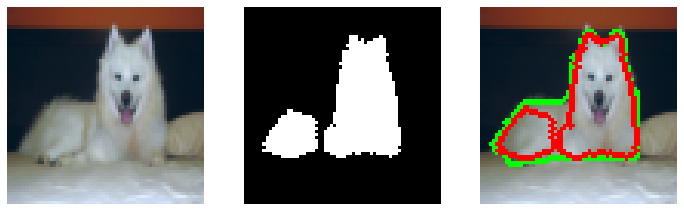

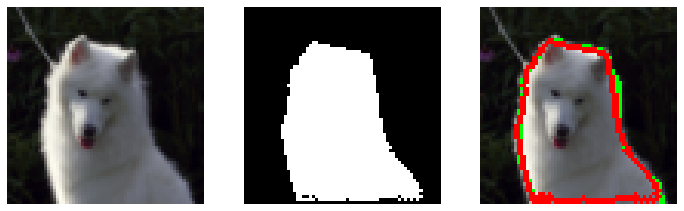

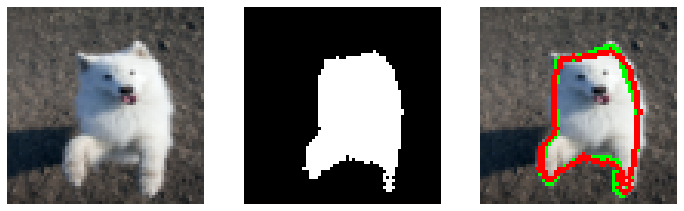

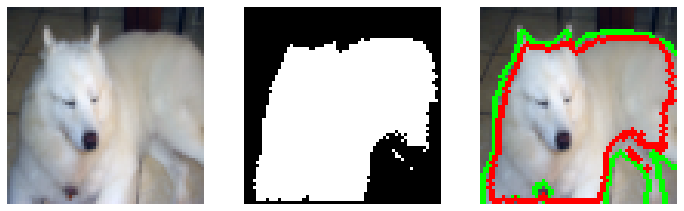

average dice: 0.8888047516382065


In [33]:
epochs = 50
model_5 = get_model_5(size_, size_)
model_5.summary()
hist_5 = model_5.fit(train_imgs, train_segs, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_segs), callbacks=[model_checkpoint])
display_history(hist_5)
dices_5 = make_prediction(model_5, test_idxs, test_imgs, test_segs)
print('average dice:', np.mean(dices_5))

**Question 11 -** Based on the figure below and average dice scores, comment on the segmentation accuracy reached for the 5 models. What is the best model and why?

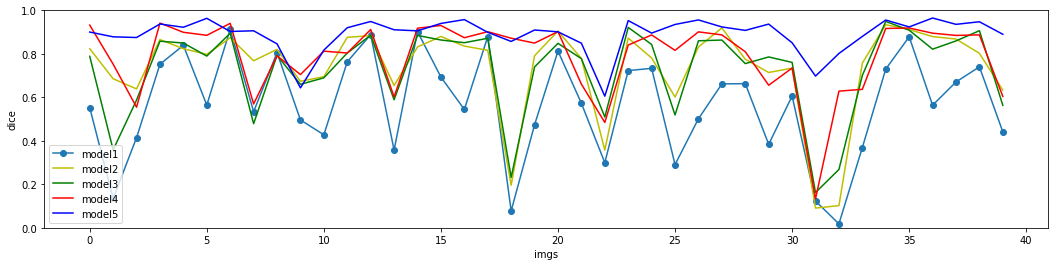

In [34]:
plt.figure(figsize=(18, 4))
plt.plot(dices_1,'o-')
plt.plot(dices_2,'y-')
plt.plot(dices_3,'g-')
plt.plot(dices_4,'r-')
plt.plot(dices_5,'b-')
plt.ylabel('dice')
plt.ylim([0,1])     
plt.xlabel('imgs')
plt.legend(['model1', 'model2','model3', 'model4','model5'], loc='lower left')
plt.show()

**Answer**: From the figure above, we can conclude that the model 5 is the best model, because it has the highest average dice score and we find that its performance is very stable. The reason is that the pre-training garantees a good feature extraction. 

***

## II - Object detection

The goal of the 2nd part is to create an automatic **face detection model** with deep learning able to accurately localize *samoyed* heads in each image by mean of a bounding box. Groundtruth bounding box coordinates are provided in XML files for 99 images. 

In [0]:
import xml.etree.ElementTree as ET
def xml2coordinates(xmlpath):
    tree = ET.parse(xmlpath)
    height = int(tree.findtext("./size/height"))
    width = int(tree.findtext("./size/width"))
    xmin = int(tree.findtext("./object/bndbox/xmin"))
    xmax = int(tree.findtext("./object/bndbox/xmax"))
    ymin = int(tree.findtext("./object/bndbox/ymin"))
    ymax = int(tree.findtext("./object/bndbox/ymax"))
    return height, width, xmin, xmax, ymin, ymax

Let us rebuild our dataset with associated bounding box coordinates (extracted from XML files).

In [0]:
folder_xml = './samoyed_xml/'

list_ = listdir_nohidden(folder_xml)
list_ = list_[1:]
idxs = []

imgs = np.ndarray((len(list_), size_, size_, 3), dtype=np.float32)
xmins = np.ndarray(len(list_), dtype=np.uint8)
xmaxs = np.ndarray(len(list_), dtype=np.uint8)
ymins = np.ndarray(len(list_), dtype=np.uint8)
ymaxs = np.ndarray(len(list_), dtype=np.uint8)
for idx, id_ in enumerate(list_):
    name = id_.split('.')[0]
    xmlpath = './samoyed_xml/'+name+'.xml'
    height, width, xmin, xmax, ymin, ymax = xml2coordinates(xmlpath)
    img = io.imread(folder_img+name+'.jpg')
    imgs[idx,...] = resize(img,output_shape=(size_,size_),mode='reflect',preserve_range=True)
    xmins[idx] = np.int(np.floor(size_*ymin/height))
    xmaxs[idx] = np.int(np.floor(size_*ymax/height))
    ymins[idx] = np.int(np.floor(size_*xmin/width))
    ymaxs[idx] = np.int(np.floor(size_*xmax/width))
    idxs.append(name)

**Question 12 -** Normalize the dataset and use the **visualize_predicted_box()** function to visualize the first eight images with super-imposed bounding boxes.

In [0]:
imgs = normalization(imgs)  # data normalization

In [0]:
def visualize_predicted_box(img, xmin, xmax, ymin, ymax):
    img = rescale_intensity(img, in_range=(np.min(img),np.max(img)), out_range=(0,1))
    mask = np.zeros(shape=img[:,:,0].shape, dtype=np.uint8)
    mask[xmin:xmax+1, ymin:ymax+1] = 1
    out = mark_boundaries(img, mask, color=(0, 1, 0))
    return out

In [22]:
plt.figure(figsize=(18, 4))
plt.subplot(241)
plt.axis('off')
plt.imshow(rescale_intensity(visualize_predicted_box(imgs[0], xmins[0], xmaxs[0], ymins[0], ymaxs[0]), in_range=(np.min(imgs[0]),np.max(imgs[0])), out_range=(0,1)))
plt.subplot(242)
plt.axis('off')
plt.imshow(rescale_intensity(visualize_predicted_box(imgs[1], xmins[1], xmaxs[1], ymins[1], ymaxs[1]), in_range=(np.min(imgs[1]),np.max(imgs[1])), out_range=(0,1)))
plt.subplot(243)
plt.axis('off')
plt.imshow(rescale_intensity(visualize_predicted_box(imgs[2], xmins[2], xmaxs[2], ymins[2], ymaxs[2]), in_range=(np.min(imgs[2]),np.max(imgs[2])), out_range=(0,1)))
plt.subplot(244)
plt.axis('off')
plt.imshow(rescale_intensity(visualize_predicted_box(imgs[3], xmins[3], xmaxs[3], ymins[3], ymaxs[3]), in_range=(np.min(imgs[3]),np.max(imgs[3])), out_range=(0,1)))
plt.subplot(245)
plt.axis('off')
plt.imshow(rescale_intensity(visualize_predicted_box(imgs[4], xmins[4], xmaxs[4], ymins[4], ymaxs[4]), in_range=(np.min(imgs[4]),np.max(imgs[4])), out_range=(0,1)))
plt.subplot(246)
plt.axis('off')
plt.imshow(rescale_intensity(visualize_predicted_box(imgs[5], xmins[5], xmaxs[5], ymins[5], ymaxs[5]), in_range=(np.min(imgs[5]),np.max(imgs[5])), out_range=(0,1)))
plt.subplot(247)
plt.axis('off')
plt.imshow(rescale_intensity(visualize_predicted_box(imgs[6], xmins[6], xmaxs[6], ymins[6], ymaxs[6]), in_range=(np.min(imgs[6]),np.max(imgs[6])), out_range=(0,1)))
plt.subplot(248)
plt.axis('off')
plt.imshow(rescale_intensity(visualize_predicted_box(imgs[7], xmins[7], xmaxs[7], ymins[7], ymaxs[7]), in_range=(np.min(imgs[7]),np.max(imgs[7])), out_range=(0,1)))
plt.show()

**Question 13 -** Using pre-trained VGG16 and fully-connected layers, build a deep regression model able to infer the 4 bounding box coordinates from a given intput image. The mean absolute error (**mean_absolute_error**) will be used as loss function. 

In [0]:
from keras.layers import Dense, Flatten

def get_model_6(img_rows, img_cols, prediction_weights=None):

    vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_rows,img_cols,3), pooling=None, classes=1000)
    
    flatten = Flatten()(vgg16_model.get_layer('block5_conv3').output)
    dense= Dense(4096)(flatten)
    dense = Dense(1024)(dense)
    dense = Dense(1024)(dense)
    dense = Dense(512)(dense)
    dense = Dense(512)(dense)
    dense = Dense(256)(dense)
    dense = Dense(4)(dense)
    
    model = Model(inputs=[vgg16_model.layers[0].output], outputs=[dense])
    if prediction_weights != None:
        model.load_weights(prediction_weights)

    model.compile(optimizer=Adam(lr=1e-4), loss='mean_absolute_error', metrics=['mean_absolute_error'])
    
    return model

In [24]:
model_6 = get_model_6(size_, size_)
model_6.summary()





58892288/58889256 [==============================] - 2s 0us/step







Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________

**Question 14 -** Divide the dataset into training and test subsets (with a ratio of 70%), run the training and display how evolves the loss function during training for both subsets. 

In [0]:
ratio = 0.7
split = np.int(len(imgs)*ratio)
train_imgs = imgs[:split,:,:,:] 
test_imgs = imgs[split:,:,:,:] 
train_xmins, train_xmaxs, train_ymins, train_ymaxs= xmins[:split], xmaxs[:split], ymins[:split], ymaxs[:split]
test_xmins, test_xmaxs, test_ymins, test_ymaxs= xmins[split:], xmaxs[split:], ymins[split:], ymaxs[split:]
train_idxs = idxs[:split] 
test_idxs = idxs[split:]

In [0]:
batch_size = 10
epochs = 200

model_checkpoint = ModelCheckpoint('./weights.hdf5', monitor='val_mean_absolute_error', verbose=0, save_best_only=True, save_weights_only=True, mode='max', period=1)

In [27]:
train_coords = np.vstack([train_xmins,train_xmaxs,train_ymins,train_ymaxs]).T
test_coords = np.vstack([test_xmins,test_xmaxs,test_ymins,test_ymaxs]).T

hist_6 = model_6.fit(train_imgs, train_coords, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(test_imgs,test_coords), callbacks=[model_checkpoint])



Train on 68 samples, validate on 30 samples
Epoch 1/200
68/68 [==============================] - 10s 154ms/step - loss: 14.7169 - mean_absolute_error: 14.7169 - val_loss: 5.8957 - val_mean_absolute_error: 5.8957
Epoch 2/200
68/68 [==============================] - 1s 8ms/step - loss: 7.3601 - mean_absolute_error: 7.3601 - val_loss: 6.2607 - val_mean_absolute_error: 6.2607
Epoch 3/200
68/68 [==============================] - 0s 7ms/step - loss: 7.0818 - mean_absolute_error: 7.0818 - val_loss: 6.1843 - val_mean_absolute_error: 6.1843
Epoch 4/200
68/68 [==============================] - 0s 7ms/step - loss: 6.9548 - mean_absolute_error: 6.9548 - val_loss: 5.7566 - val_mean_absolute_error: 5.7566
Epoch 5/200
68/68 [==============================] - 0s 7ms/step - loss: 5.9248 - mean_absolute_error: 5.9248 - val_loss: 6.6536 - val_mean_absolute_error: 6.6536
Epoch 6/200
68/68 [==============================] - 0s 7ms/step - loss: 5.4484 - mean_absolute_error: 5.4484 - val_loss: 5.1227 - val

In [0]:
def display_history_2(hist):
    plt.plot(hist.history['mean_absolute_error'])
    plt.plot(hist.history['val_mean_absolute_error'])
    plt.title('model loss')
    plt.ylabel('mean absolute error')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

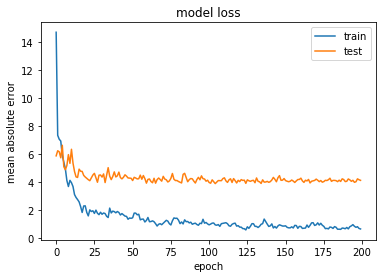

In [29]:
display_history_2(hist_6)

**Question 15 -** Use the **visualize_predicted_boxes()** function to display the prediction and groundtruth bounding boxes.

In [0]:
def visualize_predicted_boxes(img, xmin, xmax, ymin, ymax, GTxmin, GTxmax, GTymin, GTymax):
    img = rescale_intensity(img, in_range=(np.min(img),np.max(img)), out_range=(0,1))
    mask = np.zeros(shape=img[:,:,0].shape, dtype=np.uint8)
    mask[xmin:xmax+1, ymin:ymax+1] = 1
    out = mark_boundaries(img, mask, color=(1, 0, 0), background_label=2)
    mask = np.zeros(shape=img[:,:,0].shape, dtype=np.uint8)
    mask[GTxmin:GTxmax+1, GTymin:GTymax+1] = 1
    out = mark_boundaries(out, mask, color=(0, 1, 0), background_label=4)
    return out

samoyed_162


samoyed_163


samoyed_164


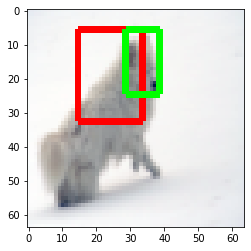

samoyed_165


samoyed_166


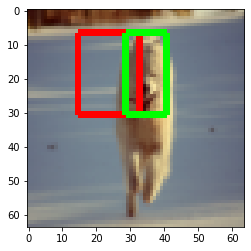

samoyed_167


samoyed_168


samoyed_169


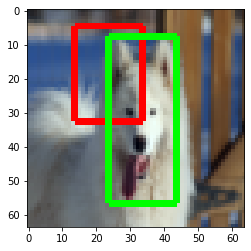

samoyed_17


samoyed_170


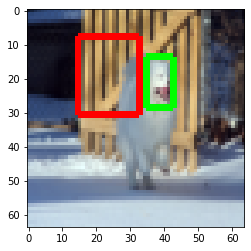

samoyed_171


samoyed_172


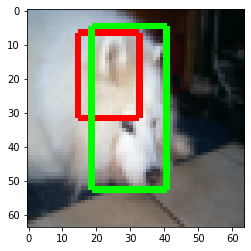

samoyed_173


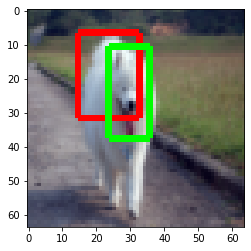

samoyed_174


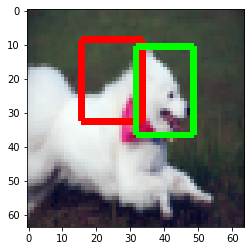

samoyed_175


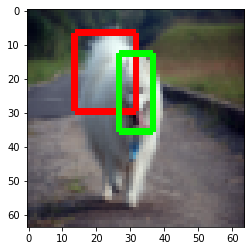

samoyed_176


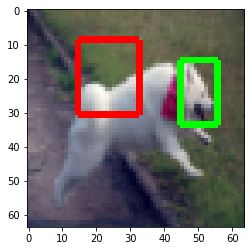

samoyed_177


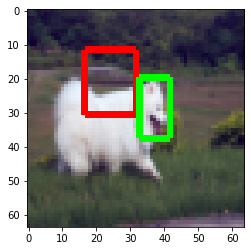

samoyed_178


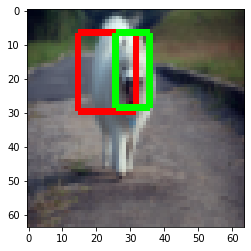

samoyed_179


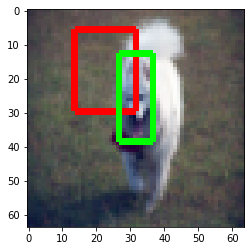

samoyed_18


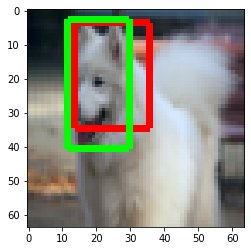

samoyed_180


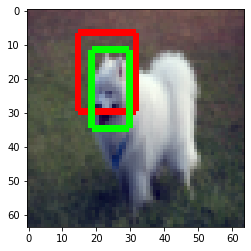

samoyed_181


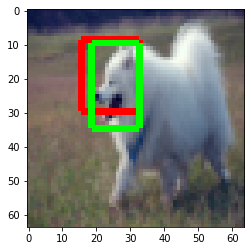

samoyed_182


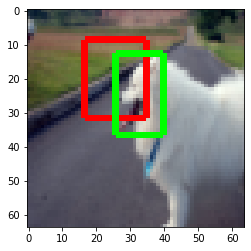

samoyed_183


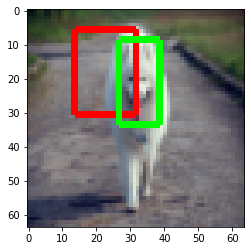

samoyed_184


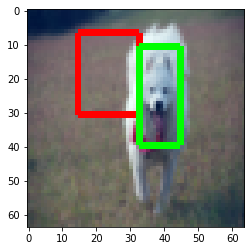

samoyed_186


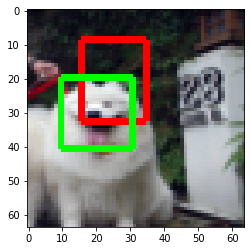

samoyed_187


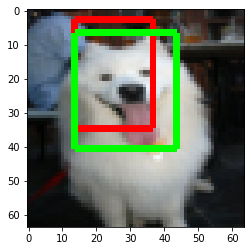

samoyed_188


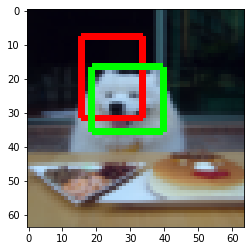

samoyed_189


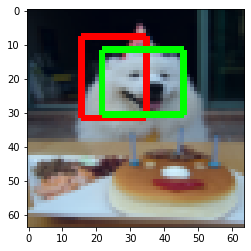

samoyed_190


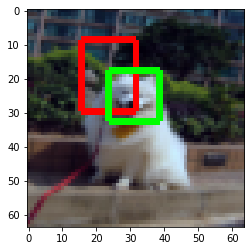

In [31]:
model_6.load_weights('./weights.hdf5')
for idx, id_ in enumerate(test_idxs):
    print(id_)
    result = model_6.predict(test_imgs[idx,:,:,:].reshape(1,64,64,3)).astype(np.uint8)
    xmin = result[0,0]
    xmax = result[0,1]
    ymin = result[0,2]
    ymax = result[0,3]
    plt.imshow(visualize_predicted_boxes(test_imgs[idx,:,:,:], xmin, xmax, ymin, ymax, test_xmins[idx], test_xmaxs[idx], test_ymins[idx], test_ymaxs[idx]))
    plt.show()

***

**Bonus question -** Come back to the semantic segmentation part and use data augmentation to improve your previous best results. Help available: https://keras.io/preprocessing/image/.